This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Modern convnet architecture patterns

A model’s “architecture” is the sum of the choices that went into creating it: which layers to use, how to configure them, and in what arrangement to connect them. These choices define the hypothesis space of your model: the space of possible functions that gradient descent can search over, parameterized by the model’s weights. Like feature engineering, a good hypothesis space encodes prior knowledge that you have about the problem at hand and its solution. For instance, using convolution layers means that you know in advance that the relevant patterns present in your input images are translation-invariant. In order to effectively learn from data, you need to make assumptions about what you’re looking for.

A good model architecture is one that reduces the size of the search space or otherwise makes it easier to converge to a good point of the search space. Just like feature engineering and data curation, model architecture is all about making the problem simpler for gradient descent to solve. And remember that gradient descent is a pretty stupid search process, so it needs all the help it can get.

In the following sections, we’ll review a few essential convnet architecture best practices: in particular, residual connections, batch normalization, and separable convolutions. Once you master how to use them, you will be able to build highly effective image models. We will apply them to our cat vs. dog classification problem.

Let’s start from the bird’s-eye view: the modularity-hierarchy-reuse (MHR) formula for system architecture.

Model architecture is more an art than a science. Experienced machine learning engineers are able to intuitively cobble together high-performing models on their first try, while beginners often struggle to create a model that trains at all. The keyword here is intuitively: no one can give you a clear explanation of what works and what doesn’t. Experts rely on pattern-matching, an ability that they acquire through extensive practical experience. You’ll develop your own intuition throughout this book. However, it’s not all about intuition either—there isn’t much in the way of actual science, but as in any engineering discipline, there are best practices.

### Modularity, hierarchy, and reuse

If you want to make a complex system simpler, there’s a universal recipe you can apply: just structure your amorphous soup of complexity into modules, organize the modules into a hierarchy, and start reusing the same modules in multiple places as appropriate (“reuse” is another word for abstraction in this context). That’s the MHR formula (modularity-hierarchy-reuse), and it underlies system architecture across pretty much every domain where the term “architecture” is used. It’s at the heart of the organization of any system of meaningful complexity, whether it’s a cathedral, your own body, the US Navy, or the Keras codebase

deep learning model architecture is primarily about making clever use of modularity, hierarchy, and reuse. You’ll notice that all popular convnet architectures are not only structured into layers, they’re structured into repeated groups of layers (called “blocks” or “modules”). For instance, the popular VGG16 architecture we used in the previous chapter is structured into repeated “conv, conv, max pooling” blocks (see figure 9.8).

Further, most convnets often feature pyramid-like structures (feature hierarchies). Recall, for example, the progression in the number of convolution filters we used in the first convnet we built in the previous chapter: 32, 64, 128. The number of filters grows with layer depth, while the size of the feature maps shrinks accordingly. You’ll notice the same pattern in the blocks of the VGG16 model

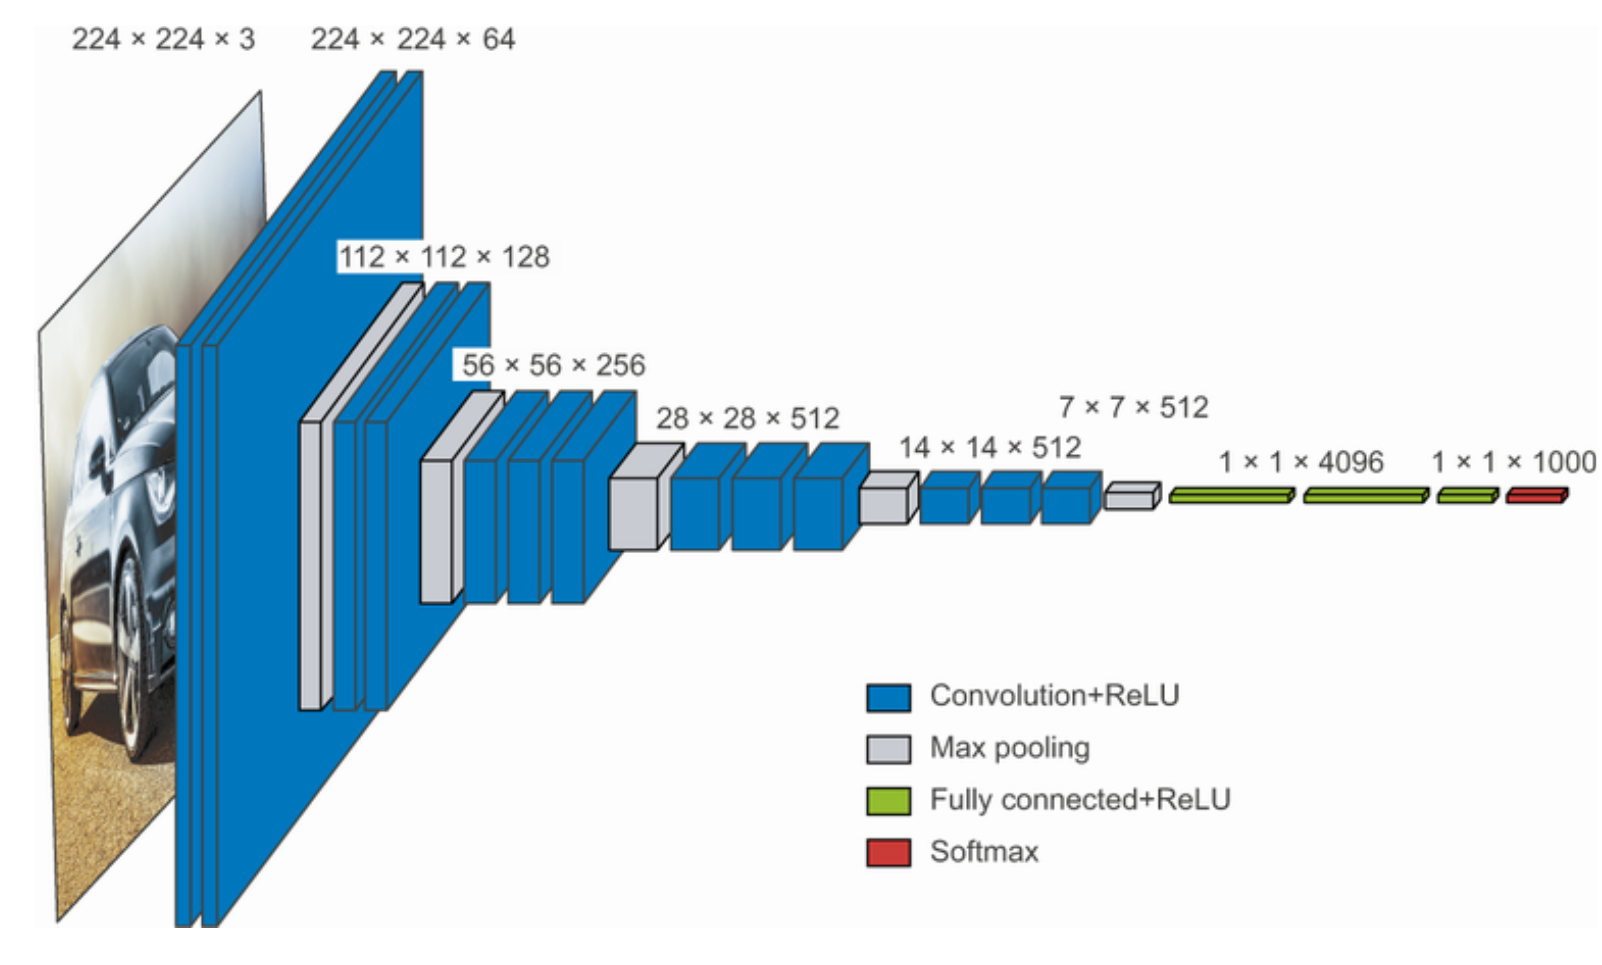

Deeper hierarchies are intrinsically good because they encourage feature reuse, and therefore abstraction. In general, a deep stack of narrow layers performs better than a shallow stack of large layers. However, there’s a limit to how deep you can stack layers, due to the problem of vanishing gradients. This leads us to our first essential model architecture pattern: residual connections.

On the importance of ablation studies in deep learning research

Deep learning architectures are often more evolved than designed—they were developed by repeatedly trying things and selecting what seemed to work. Much like in biological systems, if you take any complicated experimental deep learning setup, chances are you can remove a few modules (or replace some trained features with random ones) with no loss of performance.

This is made worse by the incentives that deep learning researchers face: by making a system more complex than necessary, they can make it appear more interesting or more novel, and thus increase their chances of getting a paper through the peer-review process. If you read lots of deep learning papers, you will notice that they’re often optimized for peer review in both style and content in ways that actively hurt clarity of explanation and reliability of results. For instance, mathematics in deep learning papers is rarely used for clearly formalizing concepts or deriving non-obvious results—rather, it gets leveraged as a signal of seriousness, like an expensive suit on a salesman.

The goal of research shouldn’t be merely to publish, but to generate reliable knowledge. Crucially, understanding causality in your system is the most straightforward way to generate reliable knowledge. And there’s a very low-effort way to look into causality: ablation studies. Ablation studies consist of systematically trying to remove parts of a system—making it simpler—to identify where its performance actually comes from. If you find that X + Y + Z gives you good results, also try X, Y, Z, X + Y, X + Z, and Y + Z, and see what happens.

### Residual connections

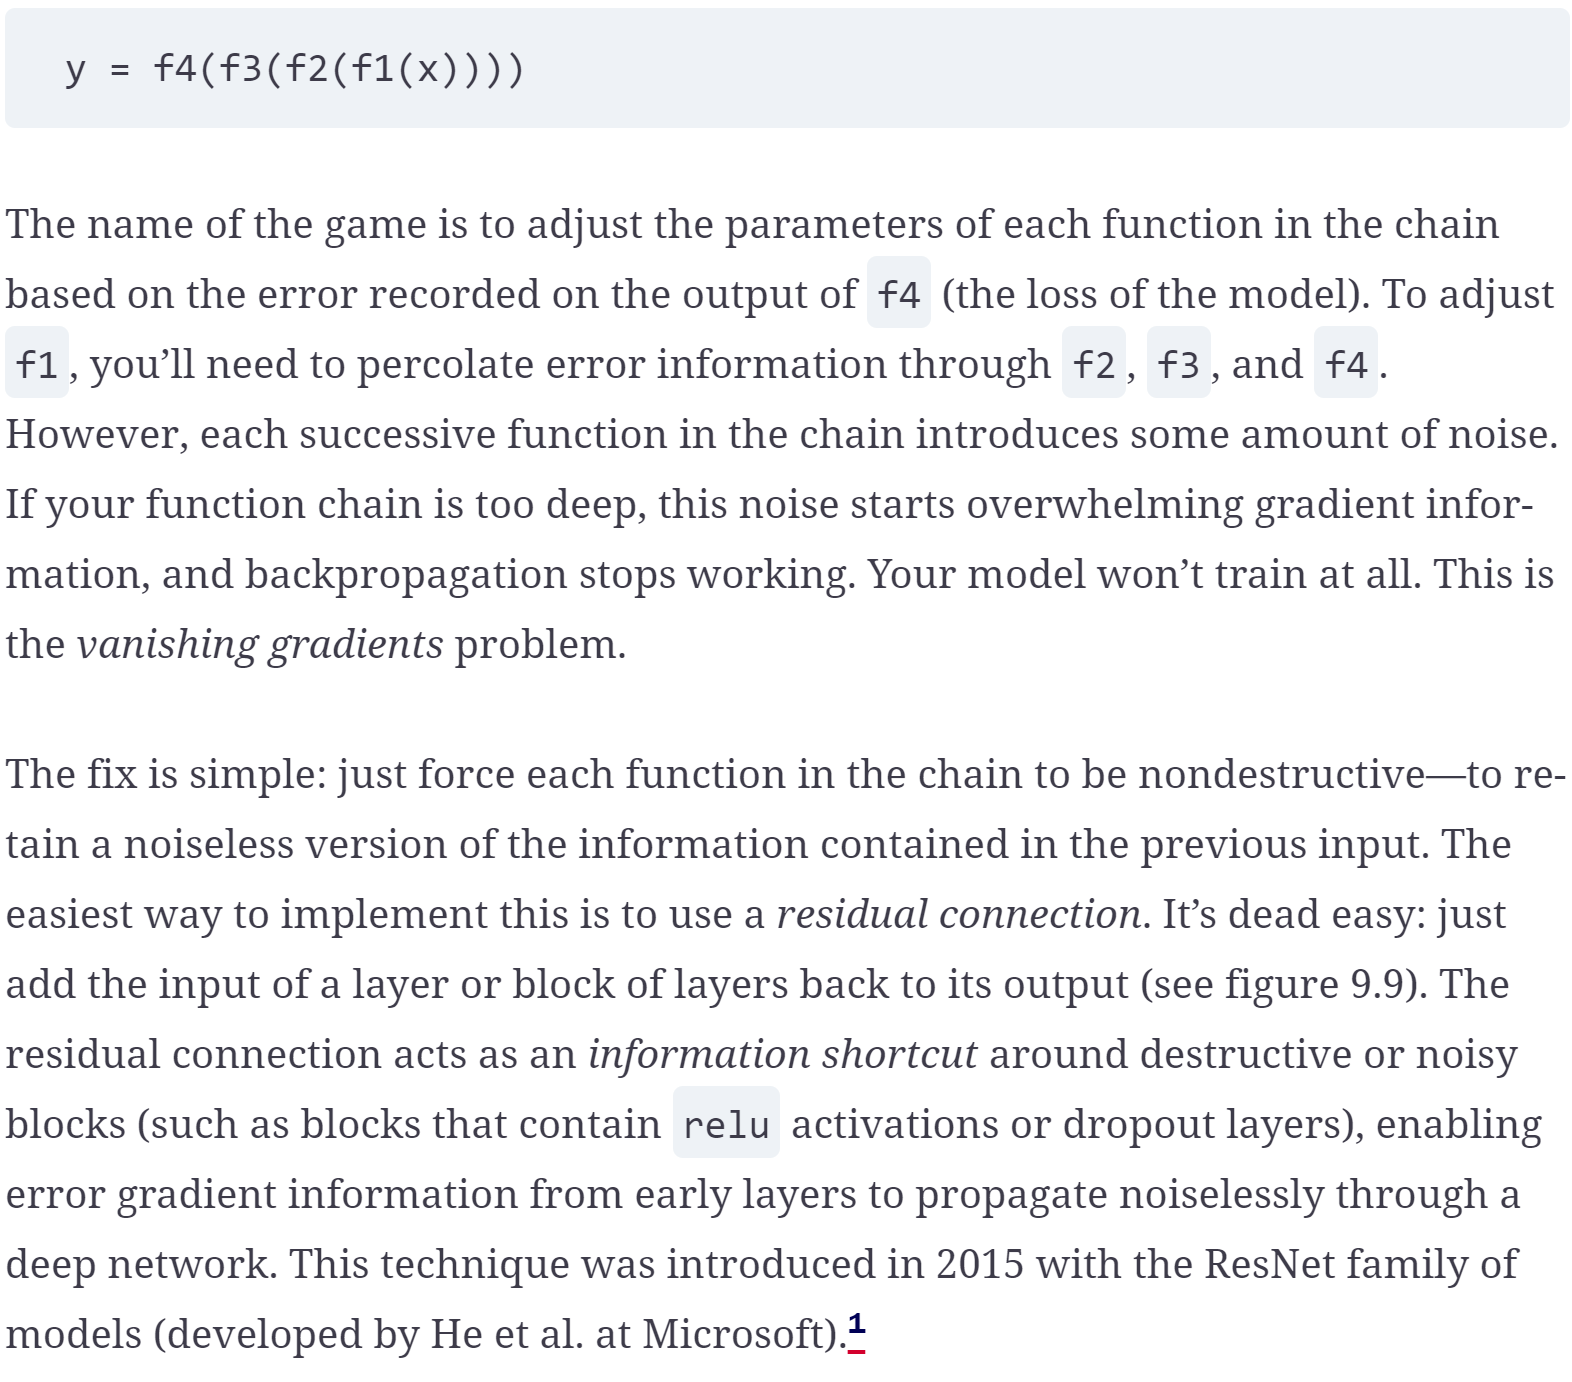

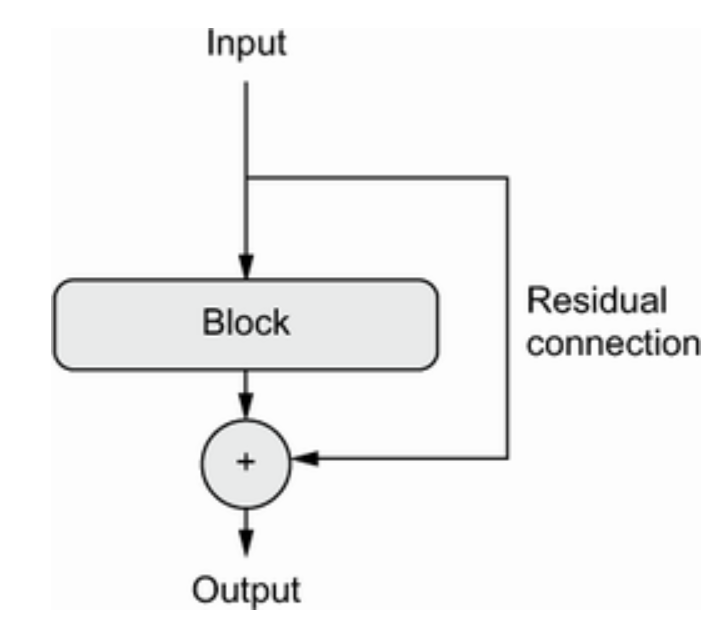

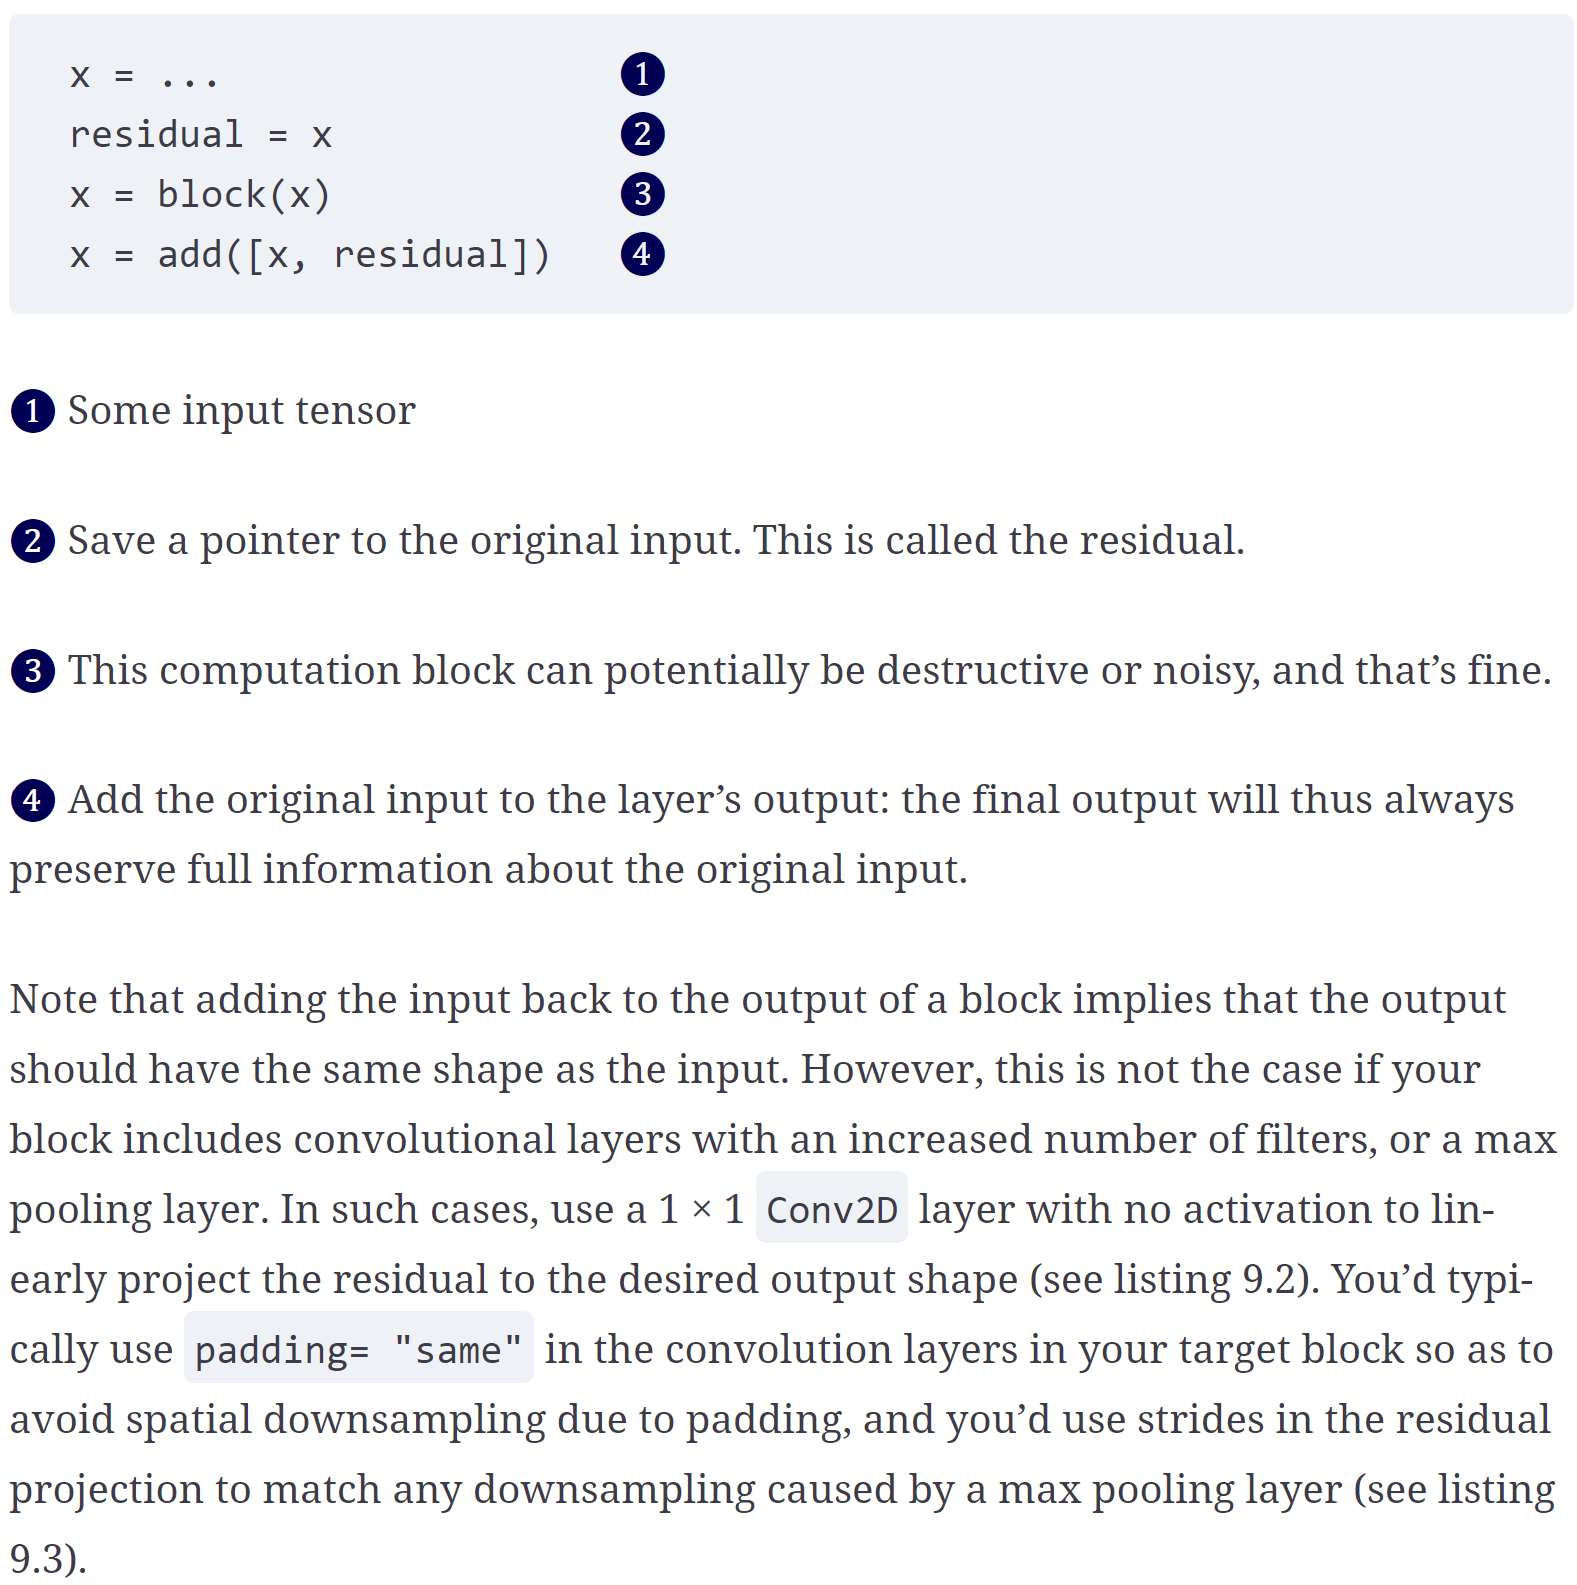


**Residual block where the number of filters changes**

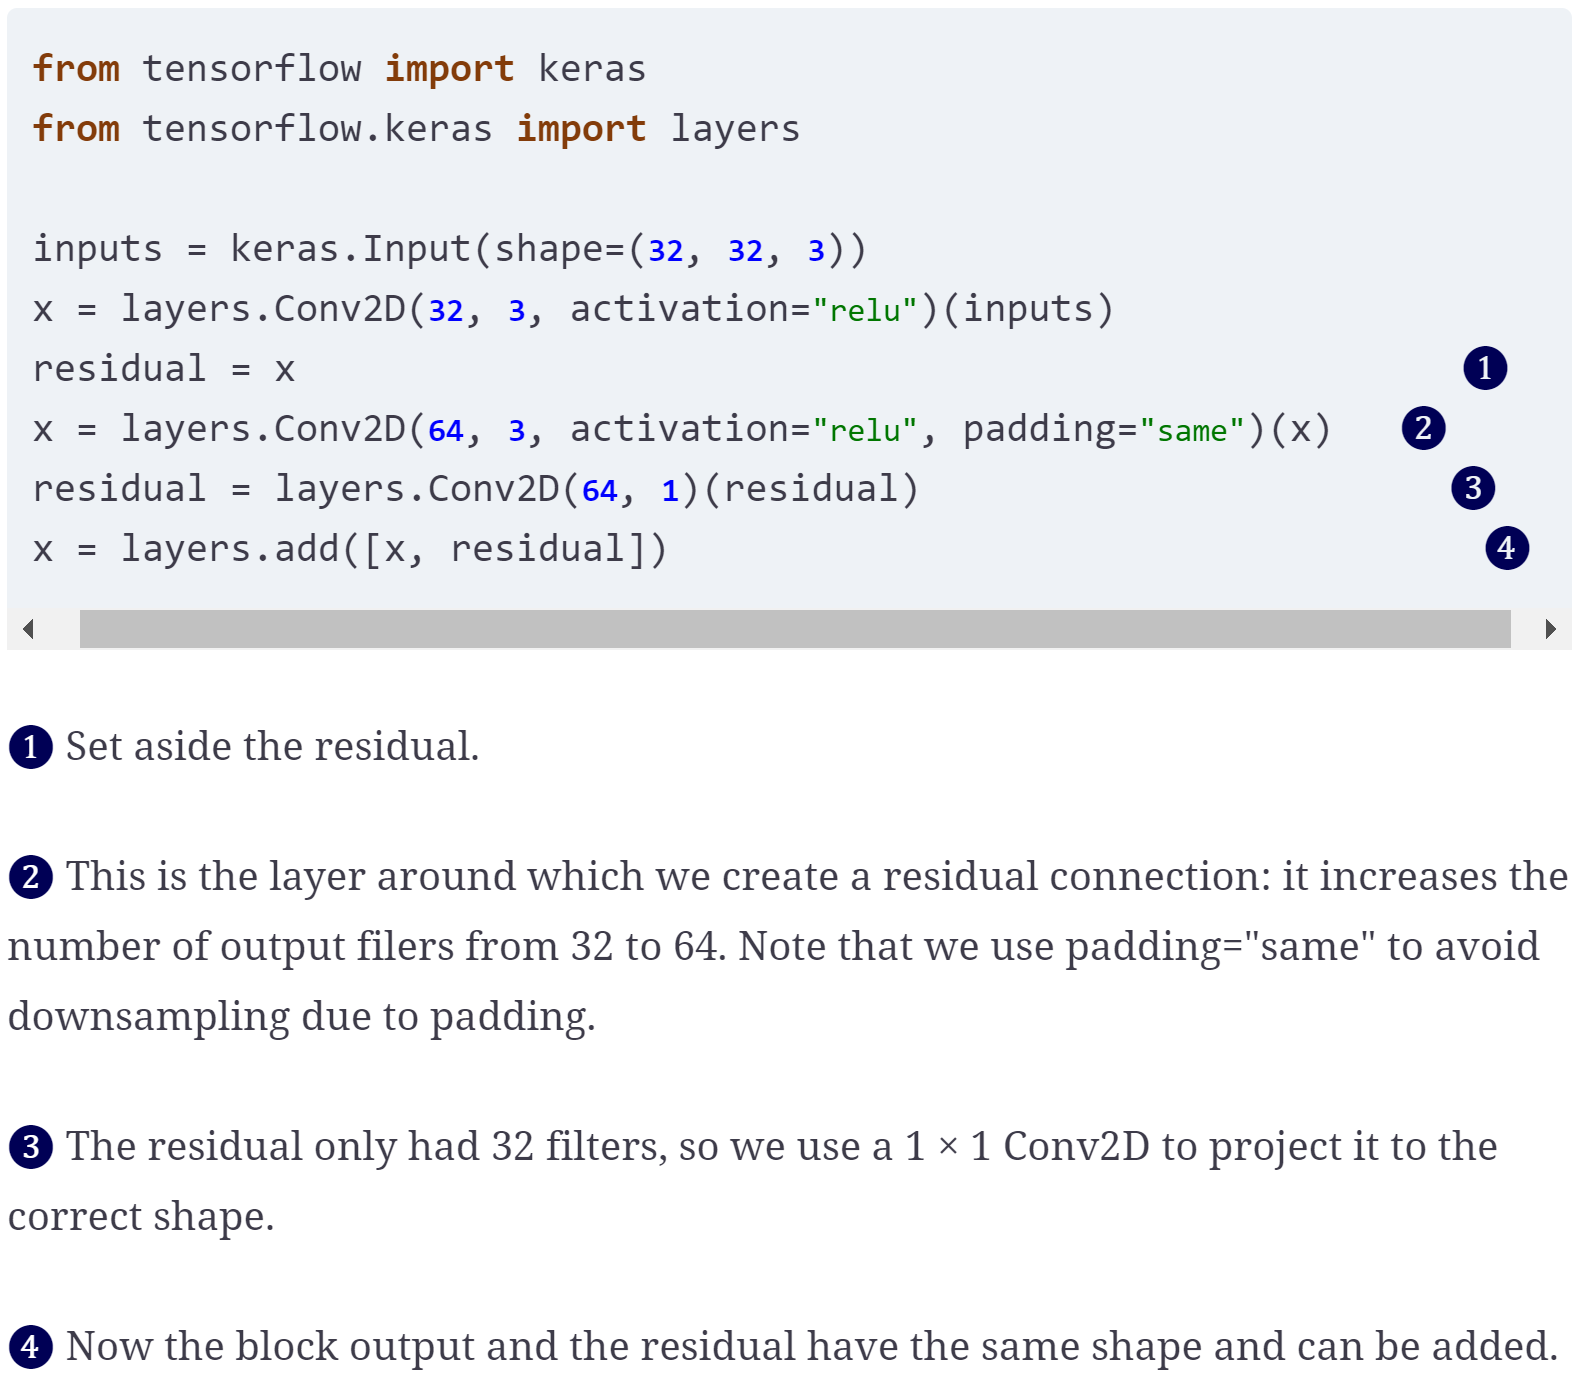

Remember, padding='same' means put a row/column of zeros around the image.  This way the output of the convolution layer with stride one will be the same size as the input.

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

**Case where target block includes a max pooling layer**

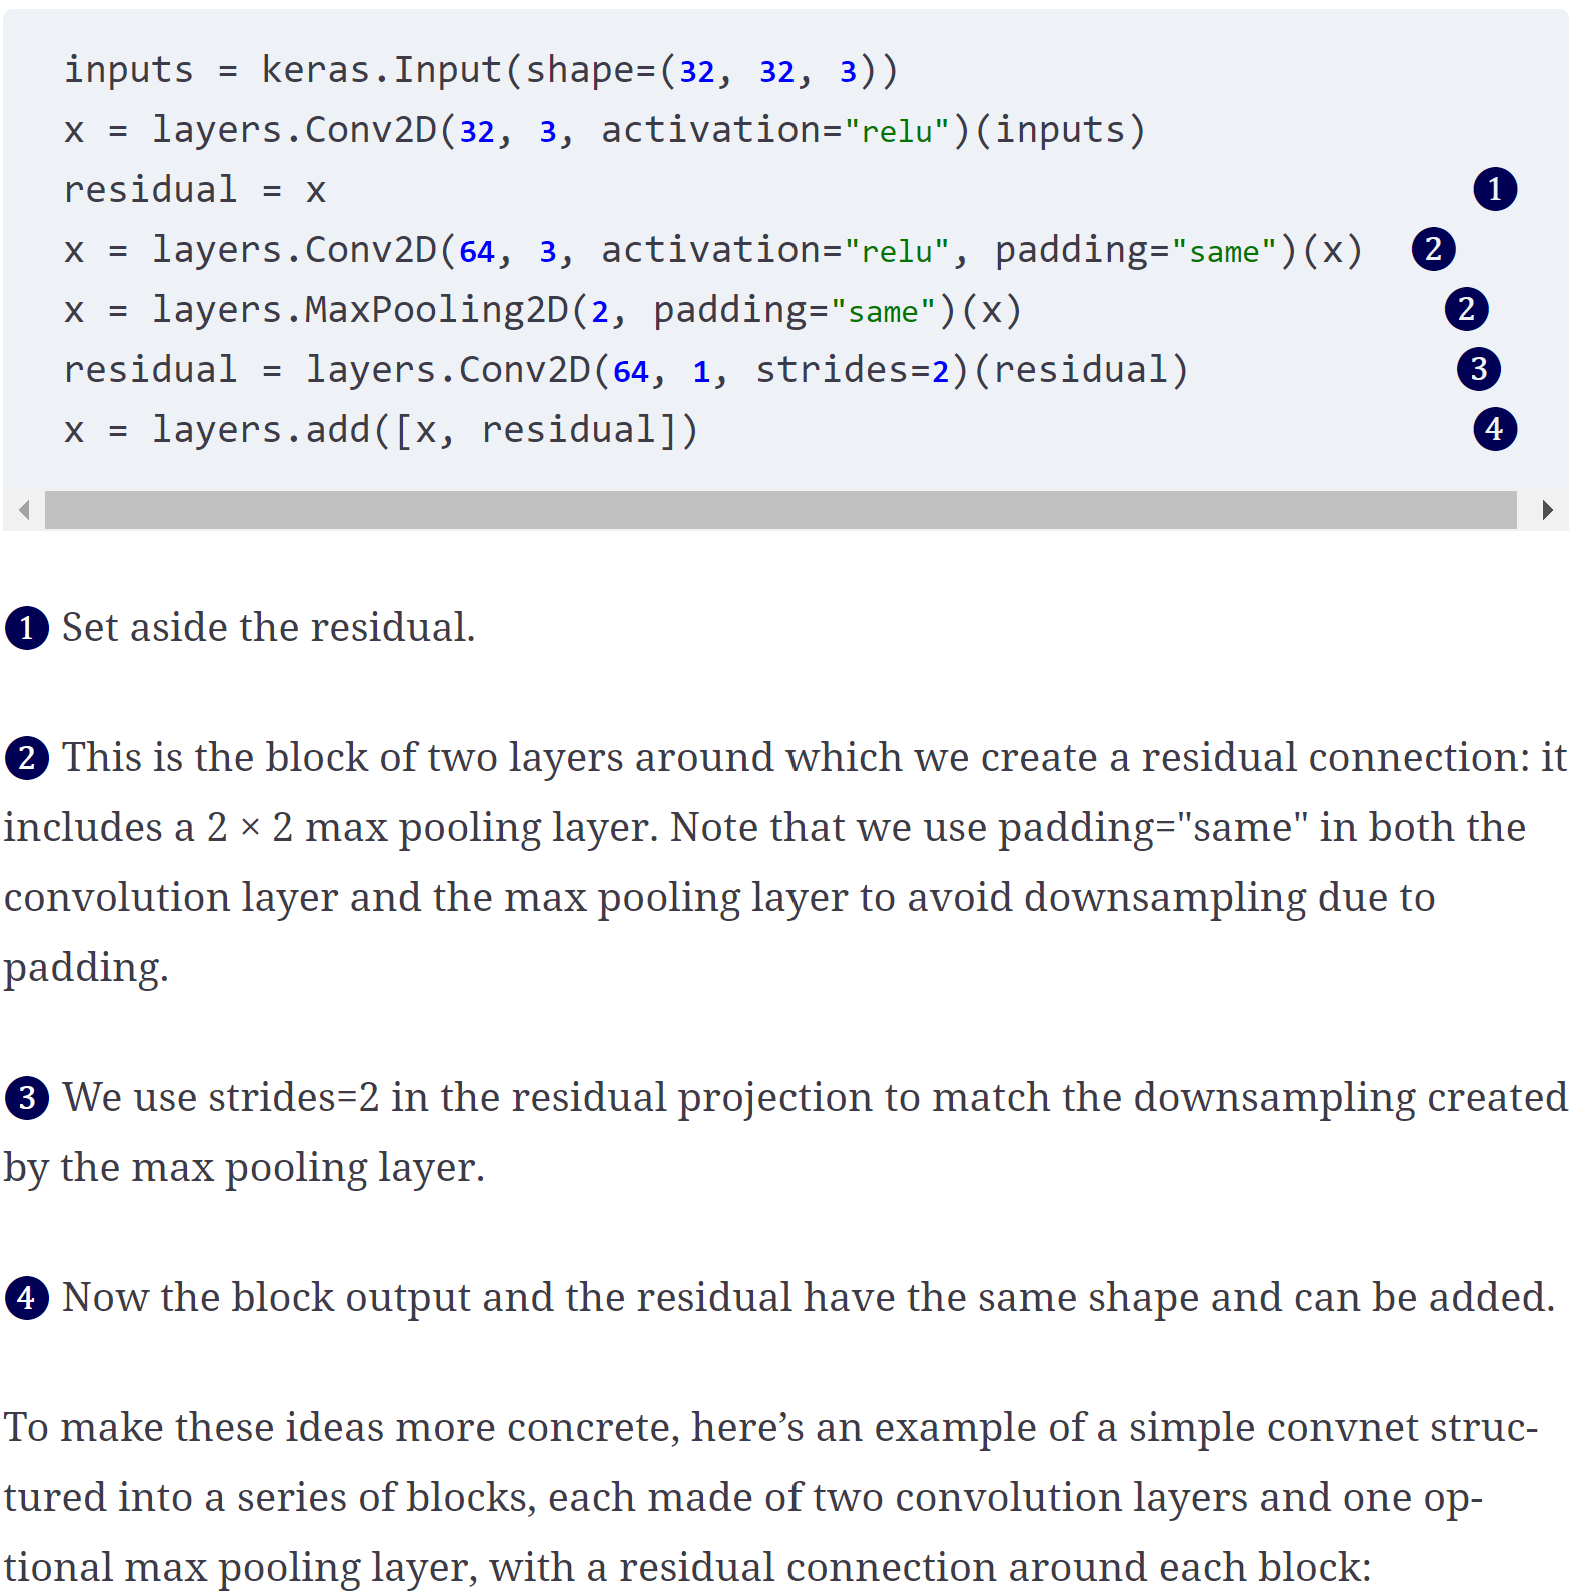

In [2]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

With residual connections, you can build networks of arbitrary depth, without having to worry about vanishing gradients.

In [3]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):  # Utility function to apply a convolutional block with a residual connection, with an option to add max pooling
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)  # If we use max pooling, we add a strided convolution to project the residual to the expected shape.
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)  # If we don’t use max pooling, we only project the residual if the number of channels has changed.
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)  # First block
x = residual_block(x, filters=64, pooling=True)  # Second block; note the increasing filter count in each block.
x = residual_block(x, filters=128, pooling=False)  # The last block doesn’t need a max pooling layer, since we will apply global average pooling right after it.
# Global Average Pooling is a pooling operation designed to replace fully connected layers in classical CNNs. The idea is to generate one feature map 
# for each corresponding category of the classification task in the last mlpconv layer. Instead of adding fully connected layers on top of the feature 
# maps, we take the average of each feature map, and the resulting vector is fed directly into the sigmoid layer.
x = layers.GlobalAveragePooling2D()(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 32, 32, 32)           896       ['rescaling[0][0]']           
                                                                                                  
 conv2d_7 (Conv2D)           (None, 32, 32, 32)           9248      ['conv2d_6[0][0]']            
                                                                                              

### Batch normalization

Normalization is a broad category of methods that seek to make different samples seen by a machine learning model more similar to each other, which helps the model learn and generalize well to new data. The most common form of data normalization is one you’ve already seen several times in this book: centering the data on zero by subtracting the mean from the data, and giving the data a unit standard deviation by dividing the data by its standard deviation. In effect, this makes the assumption that the data follows a normal (or Gaussian) distribution and makes sure this distribution is centered and scaled to unit variance:

Previous examples in this book normalized data before feeding it into models. But data normalization may be of interest after every transformation operated by the network: even if the data entering a Dense or Conv2D network has a 0 mean and unit variance, there’s no reason to expect a priori that this will be the case for the data coming out. Could normalizing intermediate activations help?

Batch normalization does just that. It’s a type of layer (BatchNormalization in Keras) introduced in 2015 by Ioffe and Szegedy;2 it can adaptively normalize data even as the mean and variance change over time during training. During training, it uses the mean and variance of the current batch of data to normalize samples, and during inference (when a big enough batch of representative data may not be available), it uses an exponential moving average of the batch-wise mean and variance of the data seen during training.

Although the original paper stated that batch normalization operates by “reducing internal covariate shift,” no one really knows for sure why batch normalization helps. There are various hypotheses, but no certitudes. You’ll find that this is true of many things in deep learning—deep learning is not an exact science, but a set of ever-changing, empirically derived engineering best practices, woven together by unreliable narratives. You will sometimes feel like the book you have in hand tells you how to do something but doesn’t quite satisfactorily say why it works: that’s because we know the how but we don’t know the why. Whenever a reliable explanation is available, I make sure to mention it. Batch normalization isn’t one of those cases.

In practice, the main effect of batch normalization appears to be that it helps with gradient propagation—much like residual connections—and thus allows for deeper networks. Some very deep networks can only be trained if they include multiple BatchNormalization layers. For instance, batch normalization is used liberally in many of the advanced convnet architectures that come packaged with Keras, such as ResNet50, EfficientNet, and Xception.

The BatchNormalization layer can be used after any layer—Dense, Conv2D, etc.:

Both Dense and Conv2D involve a bias vector, a learned variable whose purpose is to make the layer affine rather than purely linear. For instance, Conv2D returns, schematically, y = conv(x, kernel) + bias, and Dense returns y = dot(x, kernel) + bias. Because the normalization step will take care of centering the layer’s output on zero, the bias vector is no longer needed when using BatchNormalization, and the layer can be created without it via the option use_bias=False. This makes the layer slightly leaner.

Importantly, I would generally recommend placing the previous layer’s activation after the batch normalization layer (although this is still a subject of debate).

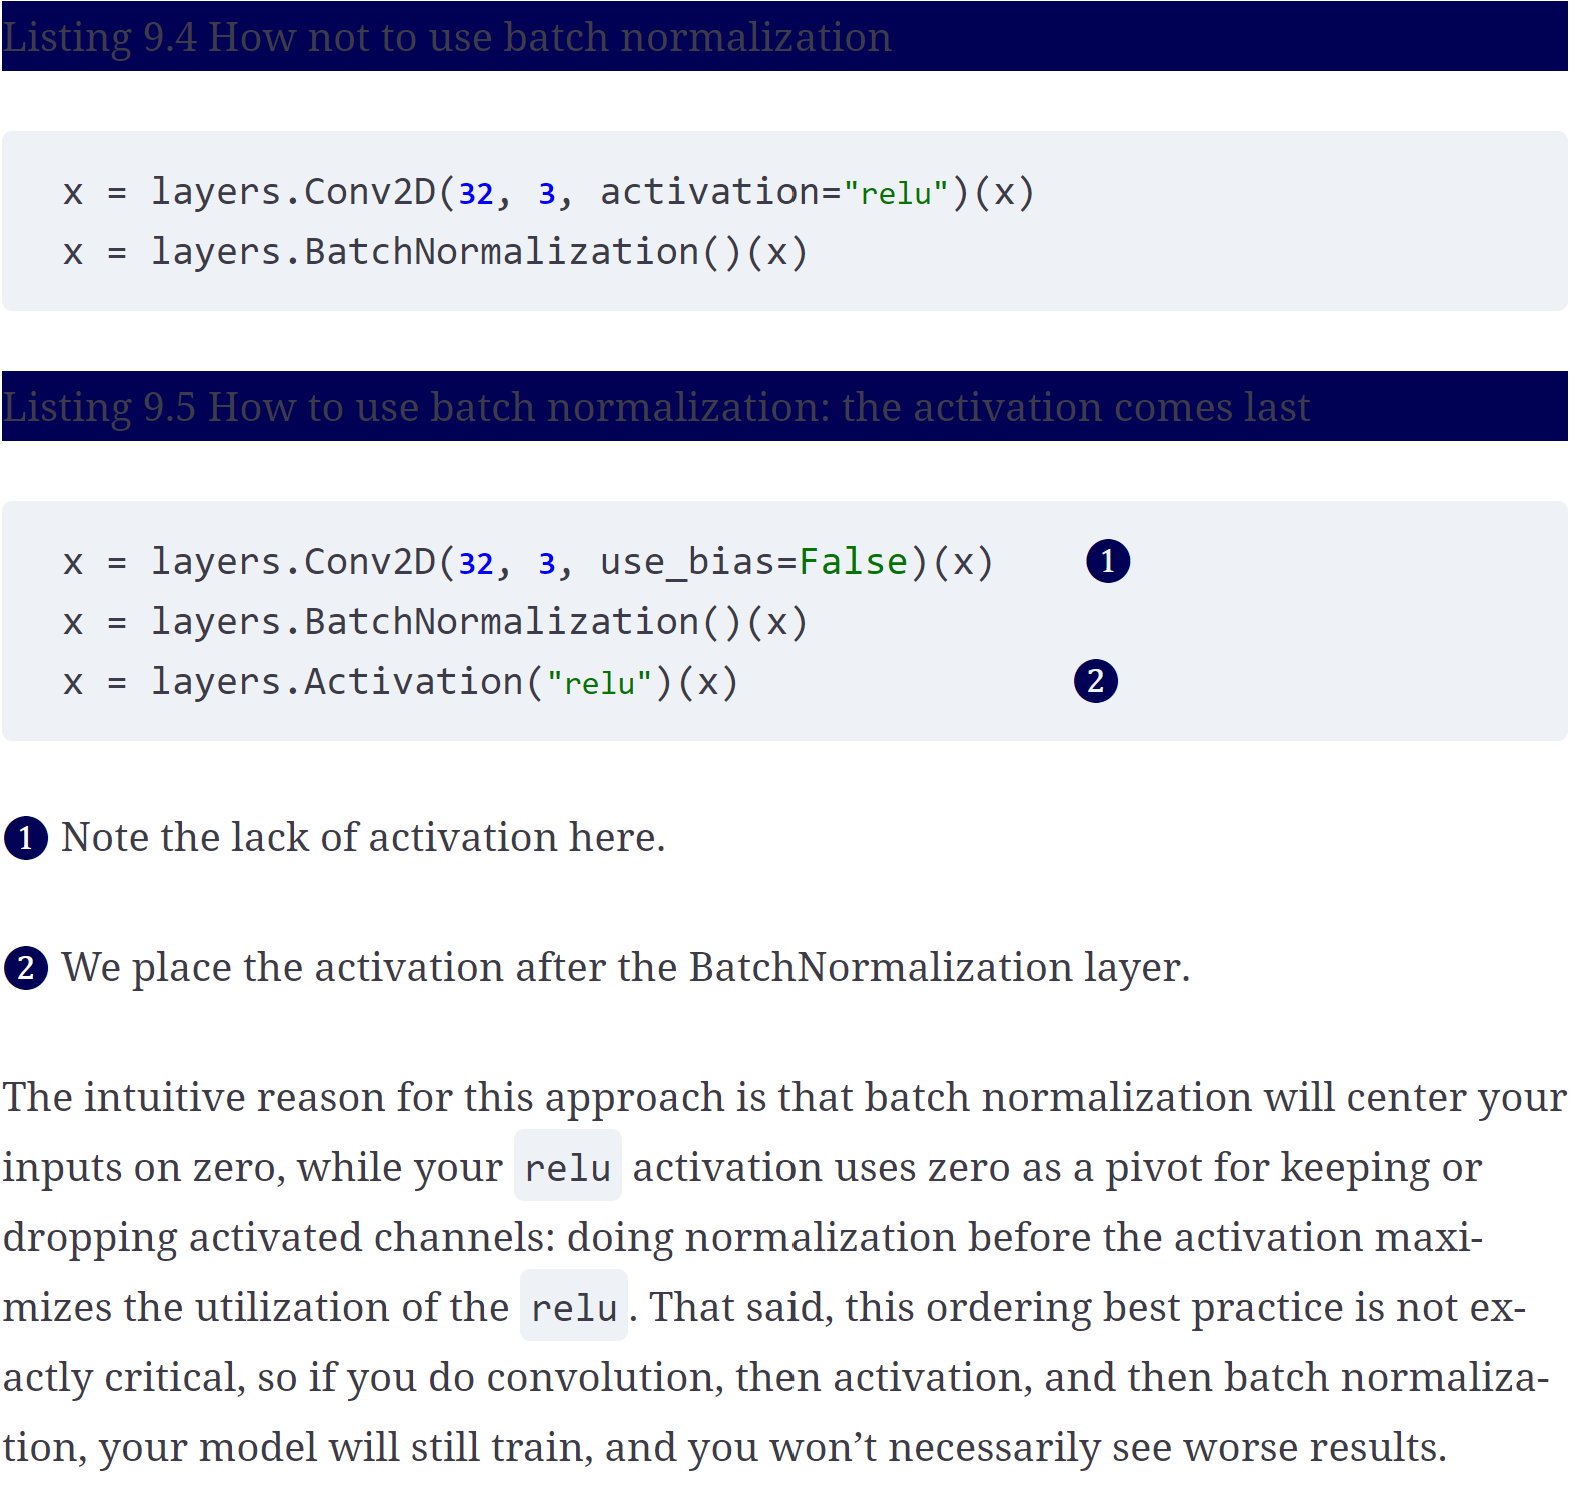

Batch normalization has many quirks. One of the main ones relates to fine-tuning: when fine-tuning a model that includes BatchNormalization layers, I recommend leaving these layers frozen (set their trainable attribute to False). Otherwise they will keep updating their internal mean and variance, which can interfere with the very small updates applied to the surrounding Conv2D layers.

### Depthwise separable convolutions

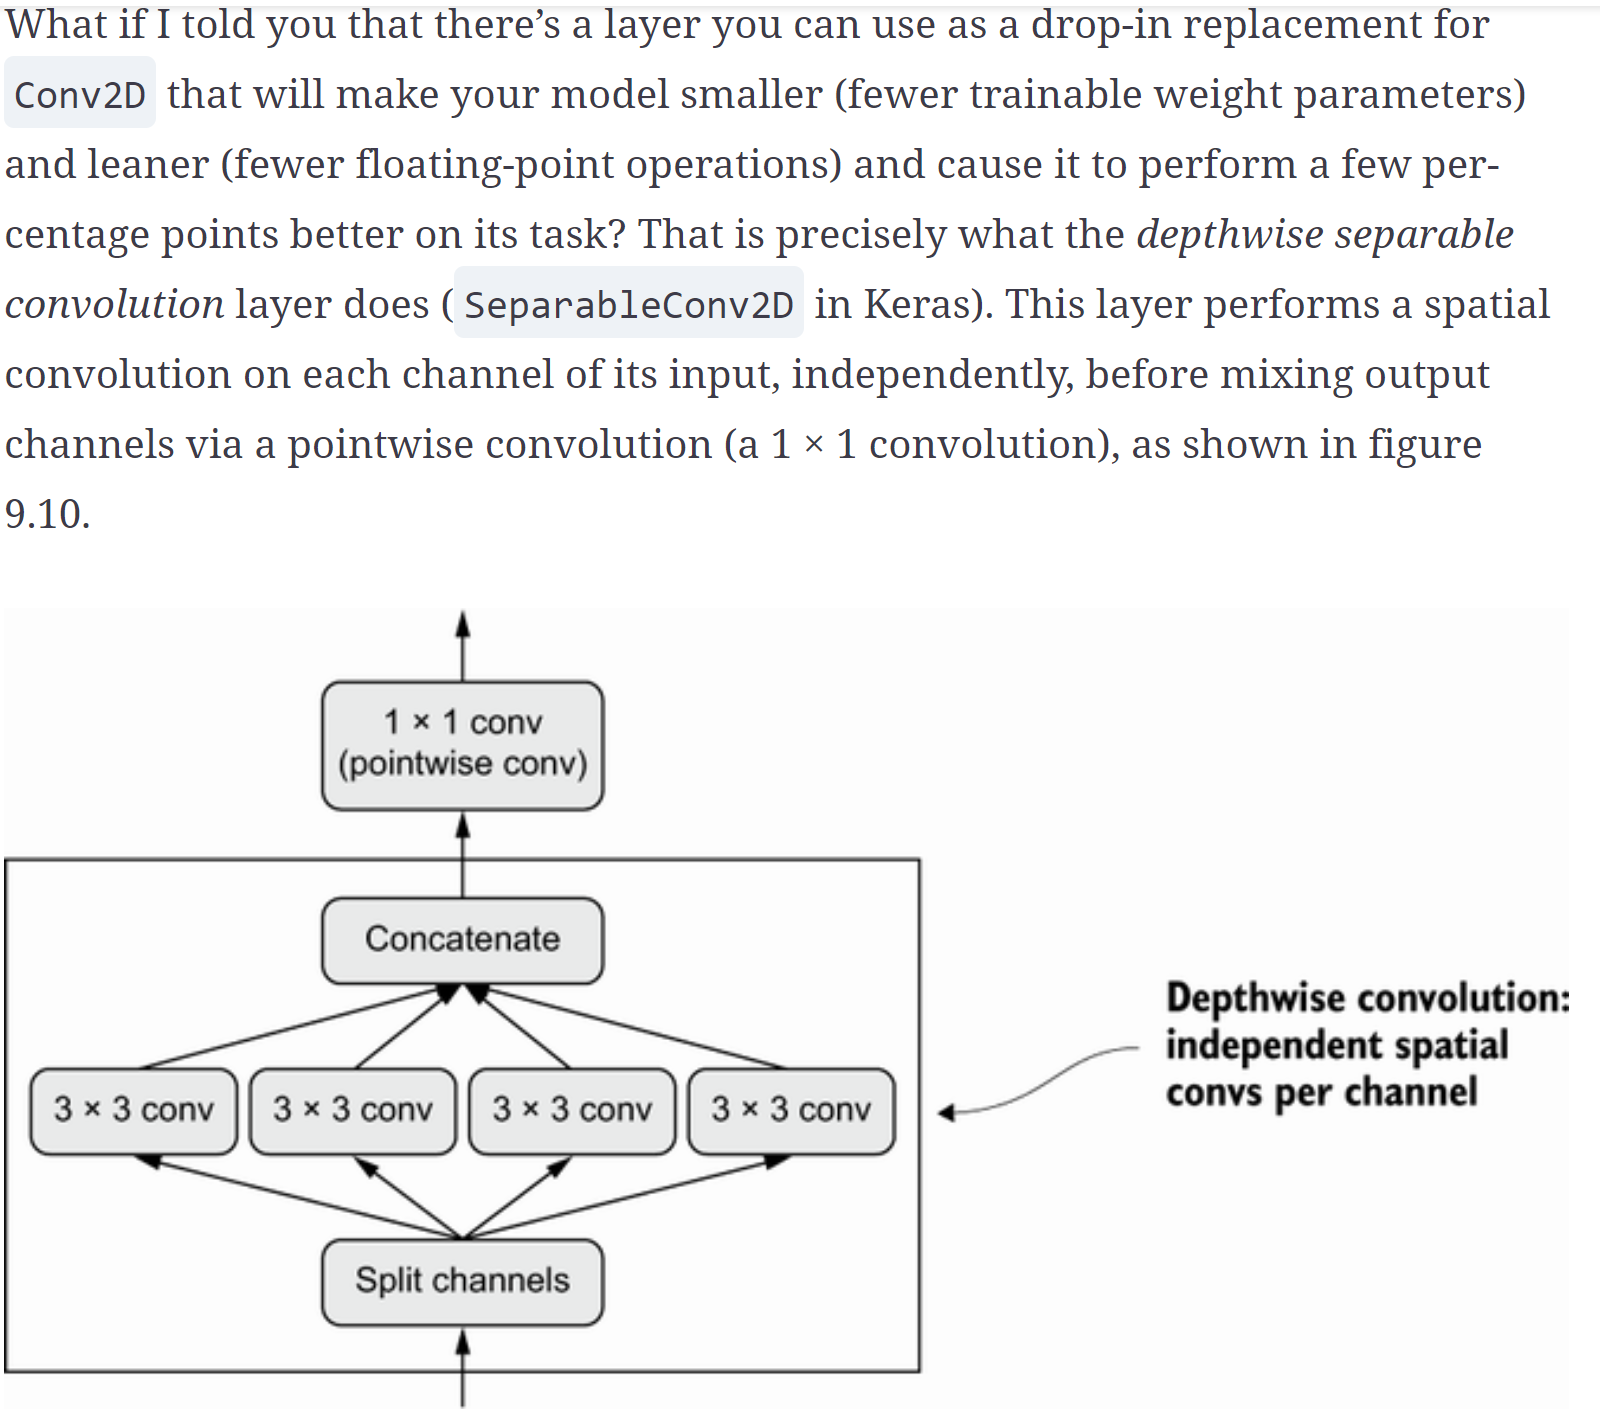

This is equivalent to separating the learning of spatial features and the learning of channel-wise features. In much the same way that convolution relies on the assumption that the patterns in images are not tied to specific locations, depthwise separable convolution relies on the assumption that spatial locations in intermediate activations are highly correlated, but different channels are highly independent. Because this assumption is generally true for the image representations learned by deep neural networks, it serves as a useful prior that helps the model make more efficient use of its training data. A model with stronger priors about the structure of the information it will have to process is a better model—as long as the priors are accurate.

Depthwise separable convolution requires significantly fewer parameters and involves fewer computations compared to regular convolution, while having comparable representational power. It results in smaller models that converge faster and are less prone to overfitting. These advantages become especially important when you’re training small models from scratch on limited data.

When it comes to larger-scale models, depthwise separable convolutions are the basis of the Xception architecture, a high-performing convnet that comes packaged with Keras. You can read more about the theoretical grounding for depthwise separable convolutions and Xception in the paper “Xception: Deep Learning with Depthwise Separable Convolutions.”3

Consider a regular convolution operation with a 3 × 3 window, 64 input channels, and 64 output channels. It uses 3*3*64*64 = 36,864 trainable parameters, and when you apply it to an image, it runs a number of floating-point operations that is proportional to this parameter count. Meanwhile, consider an equivalent depthwise separable convolution: it only involves 3*3*64 + 64*64 = 4,672 trainable parameters, and proportionally fewer floating-point operations. This efficiency improvement only increases as the number of filters or the size of the convolution windows gets larger.

As a result, you would expect depthwise separable convolutions to be dramatically faster, right? Hold on. This would be true if you were writing simple CUDA or C implementations of these algorithms—in fact, you do see a meaningful speedup when running on CPU, where the underlying implementation is parallelized C. But in practice, you’re probably using a GPU, and what you’re executing on it is far from a “simple” CUDA implementation: it’s a cuDNN kernel, a piece of code that has been extraordinarily optimized, down to each machine instruction. It certainly makes sense to spend a lot of effort optimizing this code, since cuDNN convolutions on NVIDIA hardware are responsible for many exaFLOPS of computation every day. But a side effect of this extreme micro-optimization is that alternative approaches have little chance to compete on performance—even approaches that have significant intrinsic advantages, like depthwise separable convolutions.

Despite repeated requests to NVIDIA, depthwise separable convolutions have not benefited from nearly the same level of software and hardware optimization as regular convolutions, and as a result they remain only about as fast as regular convolutions, even though they’re using quadratically fewer parameters and floating-point operations. Note, though, that using depthwise separable convolutions remains a good idea even if it does not result in a speedup: their lower parameter count means that you are less at risk of overfitting, and their assumption that channels should be uncorrelated leads to faster model convergence and more robust representations.

What is a slight inconvenience in this case can become an impassable wall in other situations: because the entire hardware and software ecosystem of deep learning has been micro-optimized for a very specific set of algorithms (in particular, convnets trained via backpropagation), there’s an extremely high cost to steering away from the beaten path. If you were to experiment with alternative algorithms, such as gradient-free optimization or spiking neural networks, the first few parallel C++ or CUDA implementations you’d come up with would be orders of magnitude slower than a good old convnet, no matter how clever and efficient your ideas were. Convincing other researchers to adopt your method would be a tough sell, even if it were just plain better.

You could say that modern deep learning is the product of a co-evolution process between hardware, software, and algorithms: the availability of NVIDIA GPUs and CUDA led to the early success of backpropagation-trained convnets, which led NVIDIA to optimize its hardware and software for these algorithms, which in turn led to consolidation of the research community behind these methods. At this point, figuring out a different path would require a multi-year re-engineering of the entire ecosystem.

### Putting it together: A mini Xception-like model

As a reminder, here are the convnet architecture principles you’ve learned so far:

Your model should be organized into repeated blocks of layers, usually made of multiple convolution layers and a max pooling layer.

The number of filters in your layers should increase as the size of the spatial feature maps decreases.

Deep and narrow is better than broad and shallow.

Introducing residual connections around blocks of layers helps you train deeper networks.

It can be beneficial to introduce batch normalization layers after your convolution layers.

It can be beneficial to replace Conv2D layers with SeparableConv2D layers, which are more parameter-efficient.

Let’s bring these ideas together into a single model. Its architecture will resemble a smaller version of Xception, and we’ll apply it to the dogs vs. cats task from the last chapter. 

!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats

!unzip -qq train.zip

from google.colab import files
files.upload()

In [6]:
inputs = keras.Input(shape=(180, 180, 3))  # images are 180x180 with three colors
x = data_augmentation(inputs)  # same augmentation configuration as before

x = layers.Rescaling(1./255)(x)  # scaling the data to range 0 - 1
# Note that the assumption that underlies separable convolution, “feature channels are largely independent,” does not hold for RGB images! 
# Red, green, and blue color channels are actually highly correlated in natural images. As such, the first layer in our model is a regular Conv2D layer.
# We’ll start using SeparableConv2D afterwards.
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)  

# We apply a series of convolutional blocks with increasing feature depth. Each block consists of two batch-normalized depthwise separable convolution
# layers and a max pooling layer, with a residual connection around the entire block.
for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)  # Because the output of the Conv2D layer gets normalized, the layer doesn’t need its own bias vector.

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)  # Because the output of the Conv2D layer gets normalized, the layer doesn’t need its own bias vector.

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)  # In the original model, we used a Flatten layer before the Dense layer. Here, we go with a GlobalAveragePooling2D layer.
x = layers.Dropout(0.5)(x)   # Like in the original model, we add a dropout layer for regularization.
outputs = layers.Dense(1, activation="sigmoid")(x)  # binary classification problem (dog or cat)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset)

Epoch 1/100


2024-03-18 17:39:51.362261: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-03-18 17:39:54.457539: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f17bc1924a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-18 17:39:54.457574: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro T2000, Compute Capability 7.5
2024-03-18 17:39:54.462671: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710783594.498467    5314 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-18 17:39:54.664088: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.19GiB with freed_by_count=0. The caller indicates that this i

63/63 [==============================] - 34s 383ms/step - loss: 0.7095 - accuracy: 0.5655 - val_loss: 0.7009 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 20s 310ms/step - loss: 0.6673 - accuracy: 0.5960 - val_loss: 0.6936 - val_accuracy: 0.5010
Epoch 3/100
63/63 [==============================] - 20s 313ms/step - loss: 0.6501 - accuracy: 0.6095 - val_loss: 0.6931 - val_accuracy: 0.5220
Epoch 4/100
63/63 [==============================] - 20s 308ms/step - loss: 0.6250 - accuracy: 0.6500 - val_loss: 0.6968 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 20s 309ms/step - loss: 0.6123 - accuracy: 0.6570 - val_loss: 0.8096 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 21s 327ms/step - loss: 0.6097 - accuracy: 0.6695 - val_loss: 0.7047 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 21s 335ms/step - loss: 0.5883 - accuracy: 0.6900 - val_loss: 0.7247 - val_accuracy: 0.5420
Epoc

## Plot accuracy

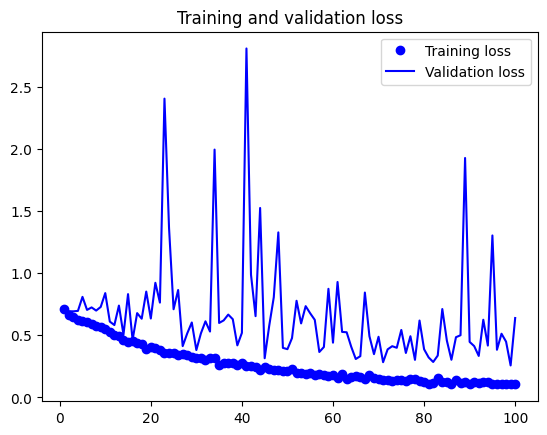

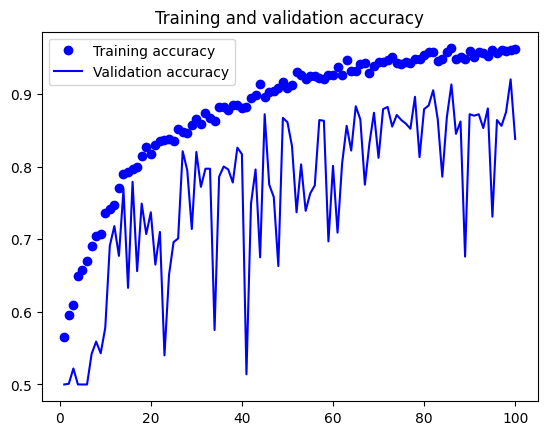

In [13]:
import matplotlib.pyplot as plt
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

epochs = range(1, len(history.history["accuracy"]) + 1)
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training accuracy")
plt.plot(epochs, val_loss, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

You’ll find that our new model achieves a test accuracy of 90.8%, compared to 83.5% for the naive model in the last chapter. As you can see, following architecture best practices does have an immediate, sizable impact on model performance!

At this point, if you want to further improve performance, you should start systematically tuning the hyperparameters of your architecture—a topic we’ll cover in detail in chapter 13. We haven’t gone through this step here, so the configuration of the preceding model is purely based on the best practices we discussed, plus, when it comes to gauging model size, a small amount of intuition.

Note that these architecture best practices are relevant to computer vision in general, not just image classification. For example, Xception is used as the standard convolutional base in DeepLabV3, a popular state-of-the-art image segmentation solution.4